# 📚 Analyse des ventes

Après un an de ventes en ligne, la société *Rester Livres* dispose de suffisamment de données pour dresser une typologie précise de ses clients et produits. Nous allons vérifier s'il existe un lien entre le sexe des clients et les catégories de produits achetés, l'âge et le montant total des achats, la fréquence d'achat ou encore la taille du panier moyen.

Hormis les librairies Pandas et Seaborn, nous utiliserons scikit-learn pour confirmer les corrélations à l'aide de tests statistiques.

## Sommaire

- [Exploration](#Exploration)
    - [Clients](#Clients)
    - [Produits](#Produits)
    - [Transactions](#Transactions)
    - [Jointures](#Jointures)
- [Nettoyage](#Nettoyage)
    - [Lignes tests](#Lignes-tests)
    - [Dates manquantes](#Dates-manquantes)
    - [Valeurs manquantes](#Valeurs-manquantes)
    - [Variables supplémentaires](#Variables-supplémentaires)
- [Analyse](#Analyse)
    - [Inégalités entre clients](#Inégalités-entre-clients)
    - [Clients professionnels](#Clients-professionnels)
    - [Clients particuliers](#Clients-particuliers)
        - [Par sexe](#Par-sexe)
        - [Par âge](#Par-âge)
    - [Produits](#Produits)
        - [Périodicité](#Périodicité)
        - [Catégories et prix](#Catégories-et-prix)
- [Tests](#Tests)
    - [Catégorie et âge (ANOVA)](#Catégorie-et-âge-(ANOVA))
    - [Catégorie et sexe (Chi 2)](#Catégorie-et-sexe-(Chi-2))
- [Références](#Références)

In [238]:
# Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import ensemble
from datetime import datetime
import scipy.stats as stats

In [239]:
sns.set( # Styles Seaborn
    style='whitegrid',
    context='notebook',
    palette='Paired',
    rc={'figure.figsize':(8,4)})

In [240]:
# Affichage des nombres : séparateur des milliers, et réduction du nombre de décimales
pd.options.display.float_format = '{:,.2f}'.format

# Exploration

On dispose de 3 jeux de données : **clients**, **produits** et **transactions**.

In [241]:
url = 'https://raw.githubusercontent.com/gllmfrnr/oc/master/p4/sources/'
clients = pd.read_csv(url + 'customers.csv')
produits = pd.read_csv(url + 'products.csv')
transactions = pd.read_csv(url + 'transactions.csv')

## Clients

Recense l'identifiant, le sexe et l'année de naissance de 8622 individus.

In [242]:
clients

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8618,c_7920,m,1956
8619,c_7403,f,1970
8620,c_5119,m,1974
8621,c_5643,f,1968


On vérifie que la table ne contient aucun doublon avant de pouvoir déterminer la clé primaire, à savoir *'client_id'* : les 8622 clients sont tous distincts.

In [243]:
def doublons(df): # Nombre de doublons dans la dataframe
    print(len(df) - len(df.drop_duplicates()), 'doublons')

doublons(clients)

0 doublons


In [244]:
def cle_primaire(df_cle): # Vérification de la clé primaire
  table_length = len(df_cle) - len(df_cle.drop_duplicates())
  if table_length == 0:
    print('Clé primaire (0 doublon)')
  else:
    print('Pas une clé primaire (', table_length, 'doublons )')
    
cle_primaire(clients['client_id'])

Clé primaire (0 doublon)


Les variables ne contiennent aucune valeur manquante ou aberrante.

In [245]:
clients.info() # Valeurs manquantes et types des variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


Dans la seule variable quantitative, *'birth'* , les années de naissance s'étalent de 1929 à 2004. 

In [246]:
clients.describe(include='all') # Indicateurs statistiques

,client_id,sex,birth
count,8623,8623,"8,623.00"
unique,8623,2,nan
top,c_7852,f,nan
freq,1,4491,nan
mean,NaN,NaN,"1,978.28"
std,NaN,NaN,16.92
min,NaN,NaN,"1,929.00"
25%,NaN,NaN,"1,966.00"
50%,NaN,NaN,"1,979.00"
75%,NaN,NaN,"1,992.00"


La variable *'sex'* n'affiche elle que 2 modalités : *f* (féminin) et *m* (masculin).

In [247]:
print('Modalités de \'sex\' :', list(clients['sex'].unique()))

Modalités de 'sex' : ['f', 'm']


## Produits

La table **produits** détaille l'identifiant, le prix et la catégorie de 3287 livres. 

In [248]:
produits

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3282,2_23,115.99,2
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1


Là encore aucun doublon ni valeur manquante. *'Id_prod'* est la clé primaire : les produits sont uniques.

In [249]:
doublons(produits) # Nombre de doublons dans la dataframe

0 doublons


In [250]:
cle_primaire(produits['id_prod']) # Vérification de la clé primaire

Clé primaire (0 doublon)


In [251]:
produits.info() # Valeurs manquantes et types des variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


La variable *'price'* compte des prix de -1 à 300. Le produit *T_0* est le seul à afficher un prix négatif de *-1*. Il faudra nettoyer cette valeur aberrante après avoir joint les 3 tables.  

In [252]:
produits.describe(include='all') # Indicateurs statistiques

,id_prod,price,categ
count,3287,"3,287.00","3,287.00"
unique,3287,nan,nan
top,0_1126,nan,nan
freq,1,nan,nan
mean,NaN,21.86,0.37
std,NaN,29.85,0.62
min,NaN,-1.00,0.00
25%,NaN,6.99,0.00
50%,NaN,13.06,0.00
75%,NaN,22.99,1.00


In [253]:
produits.sort_values(by='price') # Produit affichant un prix négatif

,id_prod,price,categ
731,T_0,-1.00,0
2355,0_202,0.62,0
2272,0_528,0.62,0
370,0_120,0.66,0
1211,0_1844,0.77,0
...,...,...,...
2779,2_30,233.54,2
1436,2_167,236.99,2
394,2_158,247.22,2
724,2_76,254.44,2


La variable *'categ'* compte 3 modalités : 0, 1 et 2. 

In [254]:
print('Modalités de \'categ\' :', list(produits['categ'].unique()))

Modalités de 'categ' : [0, 1, 2]


## Transactions

Le jeu des transactions détaille la date et les identifiants de la session, du client et du produit vendu.

In [255]:
transactions

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242
...,...,...,...,...
337011,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454
337012,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268
337013,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137
337014,2_227,2021-10-30 16:50:15.997750,s_112349,c_5


Cette fois-ci la table compte 126 doublons : on les supprime.

In [256]:
doublons(transactions) # Nombre de doublons
transactions.drop_duplicates(inplace=True) # Suppression des doublons
print(len(transactions), 'lignes après suppression des doublons') # Vérification du nombre de lignes

126 doublons
336890 lignes après suppression des doublons


La clé primaire est composée de la date et de l'identifiant client : deux transactions peuvent survenir au même moment.

In [257]:
cle_primaire(transactions[['client_id', 'date']]) # Vérification de la clé primaire

Clé primaire (0 doublon)


Nous aurons remarqué que *'client_id* et *'id_prod'* sont des clés étrangères vers **clients** et **produits**. Dans chaque clé que référence la table **transactions**, il y a moins de valeurs uniques que dans les 2 autres tables : 21 clients enregistrés n'ont pas passé commande, et 22 produits n'ont pas été vendus. Il existe toutefois un produit présent uniquement dans **transactions** : *0_2245* (103 occurences).

In [258]:
# Comparaison d'une clé unique entre 2 dataframes
def compare_keys(variable, df1, df1_name, df2, df2_name):
    df1_keys = pd.DataFrame(df1[variable].unique()) # Projection de df1 sur la variable
    df2_keys = pd.DataFrame(df2[variable].unique()) # Projection de df2 sur la variable
       
    keys_1 = df1_keys.merge( # Clés de df2 non présentes dans df1
        df2_keys, how='outer', indicator=True).loc[lambda x : x['_merge']=='right_only']  
    print('Clés de', df2_name, 'non présentes dans', df1_name + ' : ', len(keys_1))   
    
    keys_2 = df2_keys.merge(  # Clés de df1 non présentes dans df2
    df1_keys, how='outer', indicator=True).loc[lambda x : x['_merge']=='right_only']
    print('Clés de', df1_name, 'non présentes dans', df2_name + ' : ', len(keys_2))
    
compare_keys('client_id', clients, 'clients', transactions, 'transactions') # Comparaison de 'client_id' entre transactions et clients
print('- ' * 24)
compare_keys('id_prod', produits, 'produits', transactions, 'transactions') # Comparaison de la clé 'id_prod' entre transactions et produits

Clés de transactions non présentes dans clients :  0
Clés de clients non présentes dans transactions :  21
- - - - - - - - - - - - - - - - - - - - - - - - 
Clés de transactions non présentes dans produits :  1
Clés de produits non présentes dans transactions :  22


In [259]:
# Clé de 'id_prod' uniquement présente dans transactions
transactions.drop(transactions[transactions['id_prod'].isin(produits['id_prod'])].index) 

,id_prod,date,session_id,client_id
6235,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533
10802,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954
14051,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120
17486,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964
21078,0_2245,2021-03-01 00:09:29.301897,s_3,c_580
...,...,...,...,...
322710,0_2245,2021-04-06 19:59:19.462288,s_16936,c_4167
329417,0_2245,2021-03-30 23:29:02.347672,s_13738,c_7790
330490,0_2245,2021-12-03 14:14:40.444177,s_128815,c_6189
335531,0_2245,2021-04-27 18:58:47.703374,s_26624,c_1595


La commande describe() nous permet une nouvelle fois de vérifier le nombre de valeurs uniques par variable. 

Il y a moins d'identifiants de session uniques que de dates : une même session peut donc contenir plusieurs dates de transactions. Chaque client peut à son tour totaliser plusieurs sessions. 

In [260]:
transactions.describe(include='all') # Indicateurs statistiques

,id_prod,date,session_id,client_id
count,336890,336890,336890,336890
unique,3266,336855,169195,8602
top,1_369,test_2021-03-01 02:30:02.237433,s_0,c_1609
freq,1081,2,74,12855


La table ne contient aucune valeur manquante, mais comme aperçu dans les indicateurs, la variable *'date'* affiche 74 valeurs aberrantes ayant pour préfixe *test_*. Ces 74 individus concernent le produit au prix négatif (*T_0*), ainsi que des identifiants de session et de clients uniques là aussi. 

In [261]:
transactions_test = transactions.sort_values(by='date', ascending=False).head(75).reset_index() # Les 75 premiers individus triés par date
transactions_test

,index,id_prod,date,session_id,client_id
0,38779,T_0,test_2021-03-01 02:30:02.237450,s_0,ct_0
1,203239,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_0
2,245346,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
3,317345,T_0,test_2021-03-01 02:30:02.237448,s_0,ct_0
4,26814,T_0,test_2021-03-01 02:30:02.237447,s_0,ct_1
...,...,...,...,...,...
70,57755,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_1
71,59043,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_0
72,133443,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_0
73,22347,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_1


In [262]:
transactions_test = transactions_test.loc[:73] # Les 74 lignes de test

print( # Affichage des clés uniques des lignes de test 
    len(transactions_test), 'lignes tests :',
    '\n- \'id_prod\' unique :', transactions_test['id_prod'].unique(),
    '\n- \'session_id\' unique :', transactions_test['session_id'].unique(),
    '\n- \'client_id\' uniques :', transactions_test['client_id'].unique())

74 lignes tests : 
- 'id_prod' unique : ['T_0'] 
- 'session_id' unique : ['s_0'] 
- 'client_id' uniques : ['ct_0' 'ct_1']


La variable *'date'* est dans le format *object* à cause de cette valeur, alors qu'elle devrait être en *datetime*.

In [263]:
transactions.info() # Valeurs manquantes et types des variables

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336890 entries, 0 to 337015
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     336890 non-null  object
 1   date        336890 non-null  object
 2   session_id  336890 non-null  object
 3   client_id   336890 non-null  object
dtypes: object(4)
memory usage: 22.9+ MB


## Jointures

On effectue la jointure de **transactions** successivement sur **clients** et **produits**, en ne conservant que les clés de **transactions** (les clients inactifs et les produits invendus sont écartés).

La clé primaire reste celle de **transactions** : *'date'* + *'client_id'*.

In [264]:
df = transactions.merge(clients, how='left', on='client_id').merge(produits, how='left', on='id_prod') # Jointures
df

,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977,4.99,0.00
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,f,2000,65.75,2.00
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,f,1979,10.71,1.00
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,m,1963,4.20,0.00
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,f,1980,8.99,0.00
...,...,...,...,...,...,...,...,...
336885,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454,m,1969,31.99,1.00
336886,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268,m,1991,22.99,0.00
336887,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137,f,1968,11.03,0.00
336888,2_227,2021-10-30 16:50:15.997750,s_112349,c_5,f,1994,50.99,2.00


In [265]:
cle_primaire(df[['client_id', 'date']]) # Vérification de la clé primaire

Clé primaire (0 doublon)


Les variables *'price'* et *'categ'* affichent un même nombre de valeurs manquantes, qui concernent encore une fois le produit *0_2245* (uniquement présent dans **transactions** à l'origine). On cherchera plus loin à remplacer ces valeurs avec la méthode la mieux adaptée.

In [266]:
df.info() # Valeurs manquantes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336890 entries, 0 to 336889
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     336890 non-null  object 
 1   date        336890 non-null  object 
 2   session_id  336890 non-null  object 
 3   client_id   336890 non-null  object 
 4   sex         336890 non-null  object 
 5   birth       336890 non-null  int64  
 6   price       336787 non-null  float64
 7   categ       336787 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 23.1+ MB


In [267]:
df[(df['price'].isnull()) & (df['categ'].isnull())] # Individus sans prix ni catégorie

,id_prod,date,session_id,client_id,sex,birth,price,categ
6235,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533,m,1972,nan,nan
10802,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954,m,1973,nan,nan
14051,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120,f,1975,nan,nan
17486,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964,f,1982,nan,nan
21078,0_2245,2021-03-01 00:09:29.301897,s_3,c_580,m,1988,nan,nan
...,...,...,...,...,...,...,...,...
322597,0_2245,2021-04-06 19:59:19.462288,s_16936,c_4167,f,1979,nan,nan
329300,0_2245,2021-03-30 23:29:02.347672,s_13738,c_7790,f,1983,nan,nan
330371,0_2245,2021-12-03 14:14:40.444177,s_128815,c_6189,f,1984,nan,nan
335405,0_2245,2021-04-27 18:58:47.703374,s_26624,c_1595,f,1973,nan,nan


# Nettoyage

## Lignes tests

Avant de pouvoir convertir la variable *'date'* en datetime, il faut supprimer les lignes de test, vu qu'elles partagent notamment le préfixe *test_* en date.

In [268]:
lignes_test = df[ # Échantillon des lignes de test
    (df['date'].str.contains('test_')) &
    (df['price']<=0) &
    (df['id_prod']=='T_0') &  
    (df['session_id']=='s_0')]
lignes_test

,id_prod,date,session_id,client_id,sex,birth,price,categ
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1,m,2001,-1.00,0.00
2365,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1,m,2001,-1.00,0.00
2895,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1,m,2001,-1.00,0.00
5955,T_0,test_2021-03-01 02:30:02.237441,s_0,ct_0,f,2001,-1.00,0.00
7283,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1,m,2001,-1.00,0.00
...,...,...,...,...,...,...,...,...
264229,T_0,test_2021-03-01 02:30:02.237416,s_0,ct_1,m,2001,-1.00,0.00
288815,T_0,test_2021-03-01 02:30:02.237415,s_0,ct_1,m,2001,-1.00,0.00
293003,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_0,f,2001,-1.00,0.00
298292,T_0,test_2021-03-01 02:30:02.237423,s_0,ct_1,m,2001,-1.00,0.00


En supprimant ces 74 lignes de tests, on débarasse la table de ses valeurs aberrantes (*-1*), du préfixe *test_* dans les dates, ainsi que des faux clients et sessions.

In [269]:
len_df_before = len(df) # Nombre de lignes dans df avant suppression des lignes tests
df = df.drop(lignes_test.index).reset_index() # Suppression des lignes tests
print(len_df_before - len(df), 'lignes tests supprimées') # Nombre de lignes dans data après nettoyage

74 lignes tests supprimées


La clé primaire devient *'date'* : il y a maintenant autant de transactions que de dates.

In [270]:
cle_primaire(df['date']) # Vérification de la clé primaire

Clé primaire (0 doublon)


## Dates manquantes

On peut maintenant convertir la variable *'date'* en datetime. 

In [271]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # Conversion de 'date' en datetime
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336816 entries, 0 to 336815
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   index       336816 non-null  int64         
 1   id_prod     336816 non-null  object        
 2   date        336816 non-null  datetime64[ns]
 3   session_id  336816 non-null  object        
 4   client_id   336816 non-null  object        
 5   sex         336816 non-null  object        
 6   birth       336816 non-null  int64         
 7   price       336713 non-null  float64       
 8   categ       336713 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 23.1+ MB


Les transactions s'étalent sur un an, du 1er mars 2021 au 28 février 2022.

In [272]:
print('Transactions du', str(df['date'].min())[:10], 'au', str(df['date'].max())[:10]) # Dates de transaction la plus ancienne et la plus récente

Transactions du 2021-03-01 au 2022-02-28


L'histogramme des dates par catégorie de produits montre qu'il manque des données au mois d'octobre dans la catégorie 1.

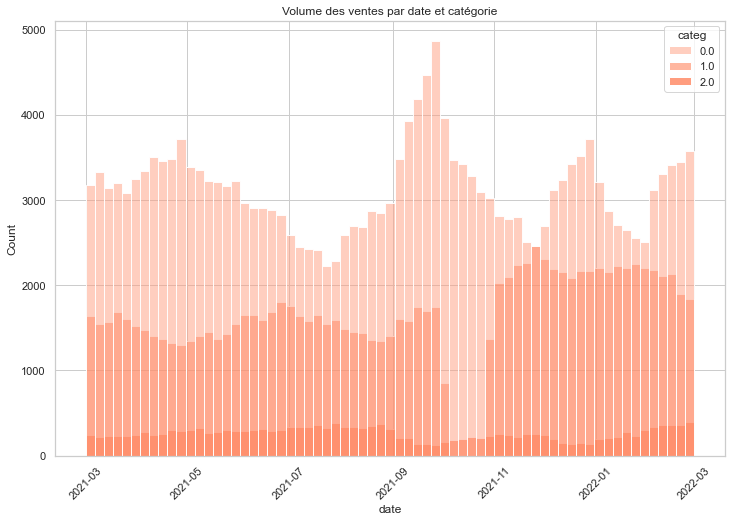

In [273]:
# URL du dossier de destination des graphiques
url_fig = 'graphiques/'

plt.figure(figsize=(12,8))
sns.histplot(data=df, x='date', hue='categ', palette=["#ff9e80", "#ff6e40", "#ff3d00"])
plt.xticks(rotation=45)
plt.title('Volume des ventes par date et catégorie')
plt.savefig(url_fig + 'histogramme_date-categorie.png', dpi=300, bbox_inches='tight')
plt.show()

Pour équilibrer l'analyse on supprime toutes les données du mois d'octobre, soit 6% du dataset.

In [274]:
len_df_before = len(df) # Nombre de lignes avant la suppression du mois d'octobre

# Transactions du mois octobre, toutes catégories
octobre = df[(df['date']>='2021-10-01') & (df['date']<='2021-10-31')]

df.drop(octobre.index, inplace=True) # Suppression des données du mois d'octobre

# Pourcentage du dataset écarté
print('Mois d\'octobre = ', round(((len_df_before - len(df)) / len_df_before * 100), 1), '% du dataset écarté')

Mois d'octobre =  6.1 % du dataset écarté


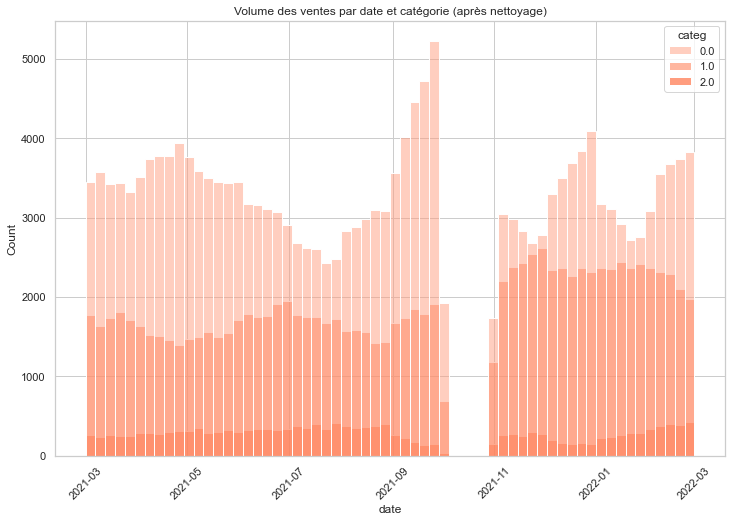

In [275]:
# Volume des ventes par date et catégorie (sans le mois d\'octobre
plt.figure(figsize=(12,8))
sns.histplot(data=df, x='date', hue='categ', palette=["#ff9e80", "#ff6e40", "#ff3d00"])
plt.xticks(rotation=45)
plt.title('Volume des ventes par date et catégorie (après nettoyage)')
plt.savefig(url_fig + 'histogramme_date-categorie_post-nettoyage.png', dpi=300, bbox_inches='tight')
plt.show()

## Valeurs manquantes

Reste à choisir une méthode pour traiter les valeurs manquantes du produit *0_2245*, à savoir son prix et sa catégorie.

Pour gérer les valeurs manquantes, 3 méthodes sont envisageables :
- supprimer les lignes concernées
- déterminer une valeur fixe
- modéliser cette valeur

In [276]:
produit_2245 = df[df['id_prod']=='0_2245'] # Échantillon du produit 0_2245
produit_2245

,index,id_prod,date,session_id,client_id,sex,birth,price,categ
6231,6235,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533,m,1972,nan,nan
10797,10802,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954,m,1973,nan,nan
14045,14051,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120,f,1975,nan,nan
17480,17486,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964,f,1982,nan,nan
21071,21078,0_2245,2021-03-01 00:09:29.301897,s_3,c_580,m,1988,nan,nan
...,...,...,...,...,...,...,...,...,...
322523,322597,0_2245,2021-04-06 19:59:19.462288,s_16936,c_4167,f,1979,nan,nan
329226,329300,0_2245,2021-03-30 23:29:02.347672,s_13738,c_7790,f,1983,nan,nan
330297,330371,0_2245,2021-12-03 14:14:40.444177,s_128815,c_6189,f,1984,nan,nan
335331,335405,0_2245,2021-04-27 18:58:47.703374,s_26624,c_1595,f,1973,nan,nan


Ici l'échantillon ne représente que 0.03% du dataset : on pourrait le supprimer sans fausser l'analyse.

In [277]:
# Pourcentage des ventes du produit 0_2245
print('Produit 0_2245 :', round((len(produit_2245) / len(df) * 100), 2), '% du dataset')

Produit 0_2245 : 0.03 % du dataset


On peut également déterminer une valeur fixe pour les 2 variables. Pour la catégorie, on peut se fier aux préfixes des identifiants de produits : *0_*, *1_* et *2_*. Ces préfixes correspondent invariablement à la catégorie du produit concerné. On choisit donc *0* comme catégorie du produit *0_2245*.

In [278]:
df_test = df.dropna() # Échantillon de l'ensemble des commandes, sans le produit 0_2245

# Conversion en string des 2 premiers caractères de la valeur de 'id_prod'
df_test['id_prod'] = df_test['id_prod'].str[:2]

print('Préfixes de \'id_prod\' :') # Pour chaque catégorie, le préfixe unique de 'id_prod'
for i in df_test['categ'].unique():
    print('- catégorie', i, ':',
        df_test[df.dropna()['categ']==i]['id_prod'].unique())

<ipython-input-278-1e08af4ef37c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['id_prod'] = df_test['id_prod'].str[:2]


Préfixes de 'id_prod' :
- catégorie 0.0 : ['0_']
- catégorie 2.0 : ['2_']
- catégorie 1.0 : ['1_']


In [279]:
# Remplacement des valeurs manquantes de la variable 'categ' par 0
df['categ'].replace(np.nan, 0, inplace=True)
produit_2245 = df[df['id_prod']=='0_2245']
produit_2245.sample(3)

,index,id_prod,date,session_id,client_id,sex,birth,price,categ
75864,75893,0_2245,2021-09-03 04:31:18.063440,s_84343,c_5056,f,1991,nan,0.00
312452,312525,0_2245,2021-07-10 11:54:44.891532,s_60426,c_6952,f,1977,nan,0.00
273136,273206,0_2245,2021-07-03 03:26:35.696673,s_57134,c_5108,m,1978,nan,0.00


Comme le démontrera l'analyse, les 3 catégories correspondent à des tranches de prix ordonnées. Les indices de corrélation confirment que cette variable des catégories est la plus à même d'expliquer le prix. Dans une moindre mesure, l'âge semble également avoir un impact sur le prix.

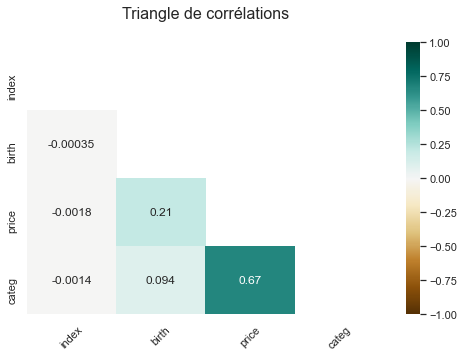

In [280]:
# Triangle de corrélations
plt.figure(figsize=(8, 5))
heatmap = sns.heatmap(df.corr(), mask=np.triu(np.ones_like(df.corr(), dtype=np.bool)), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle de corrélations', fontdict={'fontsize':16}, pad=24)
plt.xticks(rotation=45)
plt.savefig(url_fig + 'triangle_correlations.png', dpi=300, bbox_inches='tight')
plt.show()


On pourrait donc déterminer le prix en se basant sur les indicateurs de prix dans la catégorie 0. La moitié des produits y ont un prix supérieur à 9.99 : on peut choisir ce prix médian comme valeur de remplacement. On aurait également pu retenir le prix le plus fréquent (le mode) de la catégorie 0 : *4.99*.

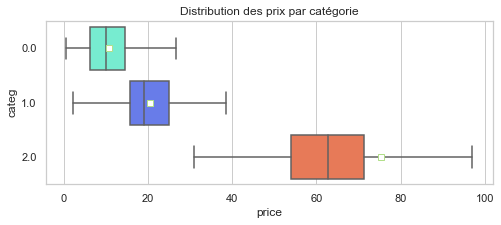

In [281]:
# Distribution et moyenne des prix par catégorie
plt.figure(figsize=(8,3))
sns.boxplot(data=df, y='categ', x='price', orient='h', showfliers=False, showmeans=True, palette=["#64ffda", "#536dfe", "#ff6e40"], meanprops={"marker":"s","markerfacecolor":"white"})
plt.title('Distribution des prix par catégorie')
plt.savefig(url_fig + 'boxplots_prix-categorie.png', dpi=300, bbox_inches='tight')
plt.show()

In [282]:
print('Catégorie 0 :',
    '\n- Prix moyen :', round(df[df['categ']==0]['price'].mean(), 2), # Prix moyen
    '\n- Prix médian :', df[df['categ']==0]['price'].median(), # Prix médian
    '\n- Mode :', df[df['categ']==0]['price'].mode().values[0]) # Prix le plus fréquent

Catégorie 0 : 
- Prix moyen : 10.65 
- Prix médian : 9.99 
- Mode : 4.99


Pour trancher entre ces 2 prix (la médiane et le mode), on peut alors s'appuyer sur une régression linéaire pour modéliser le prix probable du produit *0_2245*. On retient comme variables explicatives les colinéarités relevées plus tôt.

Les prédictions indiquent des prix moyen et médian proches de 9.99. Le mode s'en approche également, on retient donc 9.99 comme valeur de remplacement.

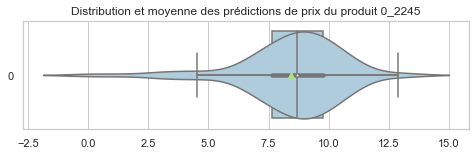

In [283]:
train = df[df['id_prod']!='0_2245'] # Échantillon d'entrainement 
y = train['price'].to_numpy() # Variable cible
features = ['birth', 'categ'] # Variables explicatives
X = pd.get_dummies(train[features]).to_numpy() # Échantillon d'entrainement (variables encodées)
X_test = pd.get_dummies(produit_2245[features]).to_numpy() # Échantillon test
model = sk.linear_model.LinearRegression() # Modèle
model.fit(X, y) # Fit les variables explicatives et la target sur le modèle
predictions = pd.Series(model.predict(X_test)) # Prédiction sur l'échantillon test

plt.figure(figsize=(8, 2))
sns.violinplot(data=predictions, orient='h', showfliers=False, showmeans=True)
sns.boxplot(data=predictions, orient='h', showfliers=False, showmeans=True)
plt.title('Distribution et moyenne des prédictions de prix du produit 0_2245')
plt.savefig(url_fig + 'boxplot_predictions-prix.png', dpi=300, bbox_inches='tight')
plt.show()

In [284]:
print('Prédictions sur la catégorie:',
    '\n- Prix moyen :', round(predictions.mean(), 2),
    '\n- Prix médian :', round(predictions.median(), 2),
    '\n- Mode :', round(predictions.mode(), 2)[0])

Prédictions sur la catégorie: 
- Prix moyen : 8.45 
- Prix médian : 8.7 
- Mode : 8.6


In [285]:
df['price'].replace(np.nan, 9.99, inplace=True)

Une forêt d'arbres décisionnels aurait aussi pu nous confirmer la catégorie. On prend comme explicatives les 2 seules variables à disposition dans l'échantillon du produit (le sexe et l'âge). La majorité des prédictions classent le produit dans la catégorie 0.

c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


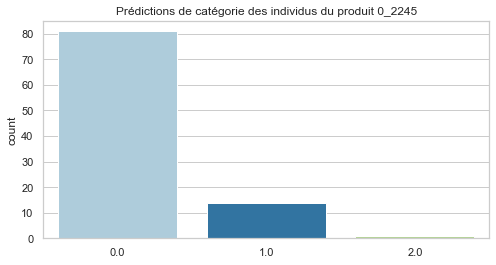

In [286]:
train = df[df['id_prod']!='0_2245']
features = ['sex', 'birth']
y = train['categ']
X = pd.get_dummies(train[features])
X_test = pd.get_dummies(produit_2245[features])
model = sk.ensemble.RandomForestClassifier()
model.fit(X, y)
predictions = model.predict(X_test)

sns.countplot(predictions)
plt.title('Prédictions de catégorie des individus du produit 0_2245')
plt.savefig(url_fig + 'countplot_predictions-categorie.png', dpi=300, bbox_inches='tight')
plt.show()

## Variables supplémentaires

Pour enrichir l'analyse, on crée quelques variables additionnelles, comme : 

- le mois de la transaction
- le nombre de produits achetés par client chaque mois (la fréquence d'achats)
- le nombre de ventes total par client sur l'année entière
- le panier moyen, 
- la taille du panier moyen pour chaque client
- le chiffre d'affaires total par client sur l'année

In [287]:
# Mois de la transaction
df['mois'] = pd.DatetimeIndex(df['date']).month # Mois, de 1 à 12
df.sample()

df['date_fixe'] = df['date'].dt.date # Variable temporaire de date fixe (jour)

df = df.merge(
    df.groupby('client_id').count()['date'].reset_index().rename(columns={'date': 'total_ventes'}),
    how='left', on='client_id')
df.sample(3)

df['ventes_mensuelles'] = round(df['total_ventes'] / 11)
df.sample()

df = df.merge(
    df.pivot_table(
        index=['client_id', 'date_fixe'], 
        values='price', 
        aggfunc='count').reset_index().pivot_table(
        index='client_id').reset_index().rename(
        columns={'price': 'taille_panier_moyen'}), 
    on='client_id', how='left')

df = df.merge(
    df.pivot_table(
        index=['client_id', 'date_fixe'], 
        values='price').reset_index().pivot_table(
        index='client_id').reset_index().rename(
        columns={'price': 'panier_moyen'}), 
    on='client_id', how='left').drop('date_fixe', axis=1)


df = df.merge(
    df.pivot_table(
    index='client_id', values='price', 
    aggfunc='sum').reset_index().rename(
    columns={'price': 'total_achats'}),
    on='client_id', how='left')
df.sample(3)

,index,id_prod,date,session_id,client_id,sex,birth,price,categ,mois,total_ventes,ventes_mensuelles,taille_panier_moyen,panier_moyen,total_achats
43762,46674,0_1112,2022-02-07 00:25:28.809598,s_161119,c_2877,m,1987,7.27,0.00,2,45,4.00,2.14,13.57,617.20
193399,206117,1_267,2021-04-23 05:46:02.526230,s_24465,c_5214,m,1971,27.99,1.00,4,14,1.00,2.33,15.88,226.42
71244,75997,1_521,2021-09-01 11:42:42.960672,s_83527,c_7107,f,2004,22.99,1.00,9,11,1.00,1.83,61.26,449.01


On divise également la population en classes, par tranches de 10 ans.

In [288]:
year = datetime.now().year # Année courante
df['age'] = year - df['birth'] # Âge du client
df.sample()

# Tranches d'âge
df['classe_age'] = '18-30'
df['classe_age'].loc[df[df['age']>=30].index] = '30-40'
df['classe_age'].loc[df[df['age']>=40].index] = '40-50'
df['classe_age'].loc[df[df['age']>=50].index] = '50-60'
df['classe_age'].loc[df[df['age']>=60].index] = '60-70'
df['classe_age'].loc[df[df['age']>=70].index] = '70-80'
df['classe_age'].loc[df[df['age']>=80].index] = '80 et +'
df.sample()

c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

,index,id_prod,date,session_id,client_id,sex,birth,price,categ,mois,total_ventes,ventes_mensuelles,taille_panier_moyen,panier_moyen,total_achats,age,classe_age
118602,126480,1_383,2021-09-03 21:00:28.962960,s_84659,c_2094,f,1987,28.99,1.00,9,10,1.00,3.33,14.29,138.86,34,30-40


# Analyse

## Inégalités entre clients

En triant les clients par chiffre d'affaires annuel, 4 clients se détachent. Leur nombre d'achats est anormalement plus élevé que celui des autres clients : on a sûrement affaire à des clients professionels.

In [289]:
ca_annuel = df.pivot_table(
    index='client_id', values=[
        'total_achats','ventes_mensuelles','taille_panier_moyen','total_ventes','panier_moyen']
    ).sort_values(by='total_achats', ascending=False).reset_index()

ca_annuel.head(10) # Les 10 clients aux plus gros chiffres d'affaires annuels

,client_id,panier_moyen,taille_panier_moyen,total_achats,total_ventes,ventes_mensuelles
0,c_1609,12.72,35.41,"151,018.91",11861,"1,078.00"
1,c_4958,55.31,7.42,"137,456.83",2463,224.00
2,c_6714,16.66,12.98,"69,493.36",4193,381.00
3,c_3454,16.62,9.39,"52,845.11",3145,286.00
4,c_8026,13.47,2.88,"2,434.49",184,17.00
5,c_7421,13.58,2.83,"2,406.17",178,16.00
6,c_7319,13.57,2.75,"2,366.20",168,15.00
7,c_3263,13.82,3.05,"2,346.34",177,16.00
8,c_8392,13.76,2.76,"2,332.08",171,16.00
9,c_2899,53.69,1.62,"2,313.54",47,4.00


Le poids de ces 4 individus risquant d'impacter l'analyse sur des variables comme le sexe ou l'âge, on distinguera les clients professionnels des particuliers.  

In [290]:
# Création d'une variable 'Type' de client (2 modalités : particulier ou professionnel)
df['client_type'] = 'B2C'
df['client_type'].loc[df[df['client_id'].isin(ca_annuel.head(4)['client_id'])].index] = 'B2B'

# Création de 2 datafra
b2b = df[df['client_type']=='B2B']
b2c = df[df['client_type']=='B2C']

df.sample(3)

c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,index,id_prod,date,session_id,client_id,sex,birth,price,categ,mois,total_ventes,ventes_mensuelles,taille_panier_moyen,panier_moyen,total_achats,age,classe_age,client_type
267327,284843,1_395,2021-08-24 16:02:53.286021,s_80104,c_3276,m,1982,28.99,1.00,8,49,4.00,2.72,13.86,618.82,39,30-40,B2C
58067,61901,0_1587,2022-01-21 09:27:08.571839,s_153013,c_1697,f,1952,14.99,0.00,1,15,1.00,1.50,15.00,228.91,69,60-70,B2C
228924,243941,0_1562,2021-09-19 22:10:09.314842,s_92444,c_4209,f,1974,14.73,0.00,9,132,12.00,2.44,12.30,"1,573.66",47,40-50,B2C


Le B2B représente 7.5% du chiffre d'affaires, et 6.9% des transactions.

In [291]:
print('Clients professionnels :',
    round(b2b['price'].sum() / df['price'].sum() * 100, 2), '% du chiffre d\'affaires annuel')

Clients professionnels : 7.48 % du chiffre d'affaires annuel


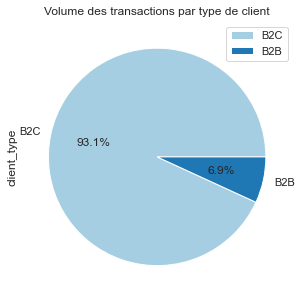

In [292]:
# Proportion des transactions entre professionnels et particuliers
plt.figure(figsize=(5,5))
df['client_type'].value_counts(normalize=True).plot(
    kind='pie',
    legend=True,
    autopct='%1.1f%%')
plt.title('Volume des transactions par type de client')
plt.savefig(url_fig + 'pie_volumes-b2c-b2b.png', dpi=300, bbox_inches='tight')
plt.show()

L'indice de Gini mesure ici l'inégalité des chiffres d'affaires de tous les clients.

> Indice de Gini : chiffre de 0 à 1 mesurant l'aire entre la bissectrice et la courbe de Lorenz

- un coefficient de 0 indiquerait une égalité parfaite (tous les points s'aligneraient alors sur la bissectrice, réduisant l'*aire* à 0)
- si l'indice était de 1, un seul client détiendrait la totalité du chiffre d'affaires (l'*aire* serait égale à celle du triangle prenant la bissectrice comme côté et 1:1 comme angle opposé)

La courbe de Lorenz montre encore une fois le chiffre d'affaires que les 4 clients (représentés par des croix) représentent à eux-seuls. 

Incide de Gini : 0.4400633281764972


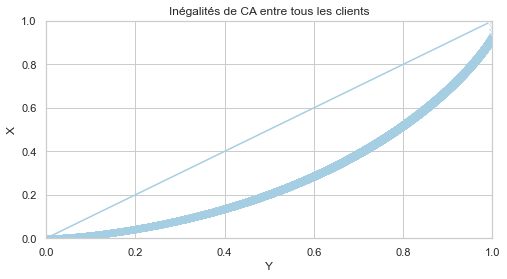

In [293]:
# Courbe de Lorenz
def lorenz(variable, title):
    X = variable.values
    X = np.sort(X)
    
    # Indice de Gini
    def gini(array):
        array
        sorted_array = array.copy()
        sorted_array.sort()
        n = array.size
        coef_ = 2. / n
        const_ = (n + 1.) / n
        weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_array)])
        return coef_*weighted_sum/(sorted_array.sum()) - const_
    print('Incide de Gini :', gini(X))
    
    # Courbe de Lorenz
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0)
    # X_lorenz[0], X_lorenz[-1]
    y = np.arange(X_lorenz.size)/(X_lorenz.size-1)
    lorenz = pd.DataFrame()
    lorenz['X'] = pd.Series(X_lorenz)
    lorenz['Y'] = pd.Series(y)
    sns.scatterplot(data=lorenz, x='Y', y='X', marker='x')

    # Diagonale
    a = np.arange(0,1,.01)
    x = a
    y = a
    
    # Graphique
    sns.lineplot(x=x,y=y)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title(title)
    plt.show()
    
# Inégalité des chiffres d'affaires annuels de tous les clients
lorenz(ca_annuel['total_achats'], 'Inégalités de CA entre tous les clients')

L'indice de Gini est naturellement plus faible si on exclut les 4 professionnels.

Incide de Gini : 0.39549570238232845


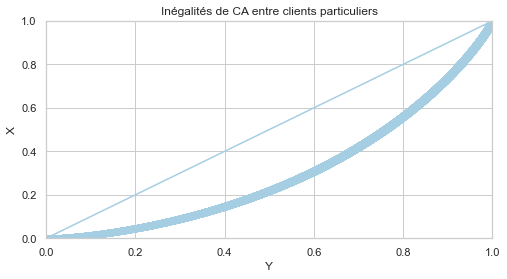

In [294]:
# Inégalité des chiffres d'affaires annuels des clients particuliers
lorenz(b2c.pivot_table(index='client_id')['total_achats'], 'Inégalités de CA entre clients particuliers')

## Clients professionnels

Les variables *'sex'* et *'age'* n'ont aucun intérêt ici. Nous remarquons que le client *c_4958* a un panier moyen supérieur aux 3 autres professionnels, alors que sa fréquence d'achat est la plus faible.

In [295]:
b2b.pivot_table(index='client_id').reset_index() # Profil des 4 clients B2B

,client_id,age,birth,categ,index,mois,panier_moyen,price,taille_panier_moyen,total_achats,total_ventes,ventes_mensuelles
0,c_1609,41,1980,0.21,"167,399.98",6.35,12.72,12.73,35.41,"151,018.91",11861,"1,078.00"
1,c_3454,52,1969,0.61,"167,890.56",6.28,16.62,16.80,9.39,"52,845.11",3145,286.00
2,c_4958,22,1999,1.63,"166,388.45",6.00,55.31,55.81,7.42,"137,456.83",2463,224.00
3,c_6714,53,1968,0.46,"168,035.64",6.26,16.66,16.57,12.98,"69,493.36",4193,381.00


Le volume des transactions par catégorie montre des habitudes différentes chez chacun de ces clients. 

Le client *c_1609* ne consomme pas du tout la catégorie 2, tandis que le client *c_4858* est le seul à consommer principalement cette catégorie. Vu que ce client détient de loin le plus gros panier moyen, la catégorie pourrait influer sur le prix du livre. 

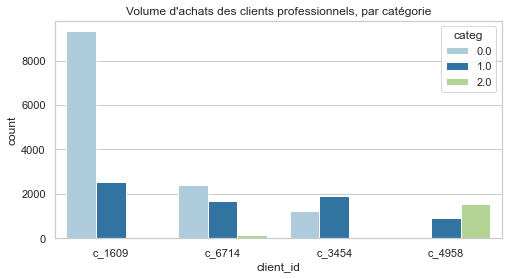

In [296]:
sns.countplot(data=b2b, x='client_id', hue='categ')
plt.title('Volume d\'achats des clients professionnels, par catégorie')
plt.savefig(url_fig + 'countplot_b2b-categories.png', dpi=300, bbox_inches='tight')
plt.show()

La distribution des prix d'achats confirme cette intuition : le client *c_4958* achète des livres bien plus chers les 3 autres clients.

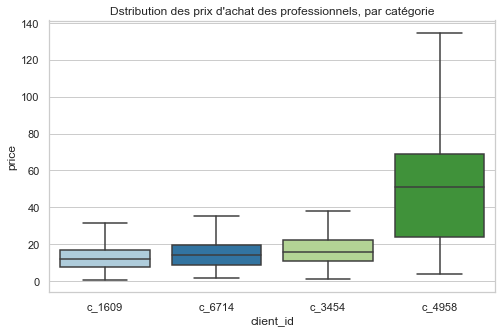

In [297]:
plt.figure(figsize=(8,5))
sns.boxplot(data=b2b, y='price', x='client_id', showfliers=False)
plt.title('Dstribution des prix d\'achat des professionnels, par catégorie')
plt.savefig(url_fig + 'boxplots_b2b-prix.png', dpi=300, bbox_inches='tight')
plt.show()

La périodicité des achats présente des points communs en fonction des catégories là encore :

- la catégorie 0 est surtout achetée en septembre
- la catégorie 1 en décembre
- la catégorie 2 au mois de février

Client c_1609


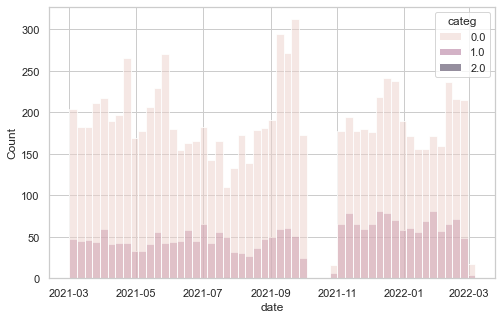

Client c_6714


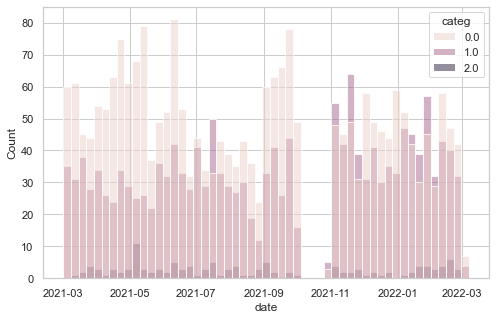

Client c_3454


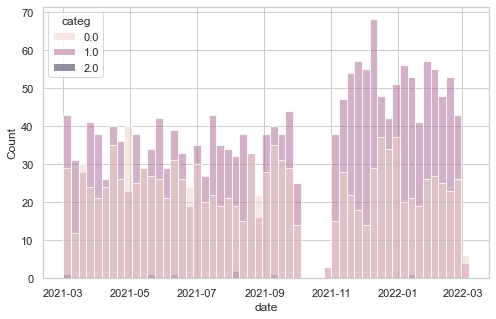

Client c_4958


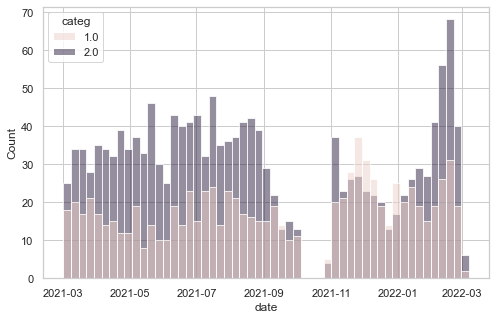

In [298]:
for i in b2b['client_id'].unique():
    print('Client', i)
    plt.figure(figsize=(8,5))
    sns.histplot(data=b2b[b2b['client_id']==i], x='date', hue='categ', binwidth=7)
    plt.show()

## Clients particuliers

### Par sexe

La pyramide des âges ne montre aucune différence entre les hommes et les femmes.

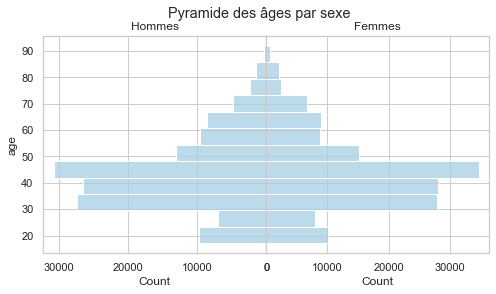

In [299]:
fig, axes = plt.subplots(1, 2)
fig.suptitle('Pyramide des âges par sexe')

sns.histplot(ax=axes[0], y=b2c[b2c['sex']=='m']['age'], bins=12)
axes[0].invert_xaxis()
axes[0].set_title('Hommes')

sns.histplot(ax=axes[1], y=b2c[b2c['sex']=='f']['age'], bins=12)
axes[1].set_yticklabels([])
axes[1].set_ylabel('')
axes[1].set_title('Femmes')

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(url_fig + 'pyramide_ages.png', dpi=300, bbox_inches='tight')
plt.show()

La périodicité des ventes est la même pour les 2 sexes.

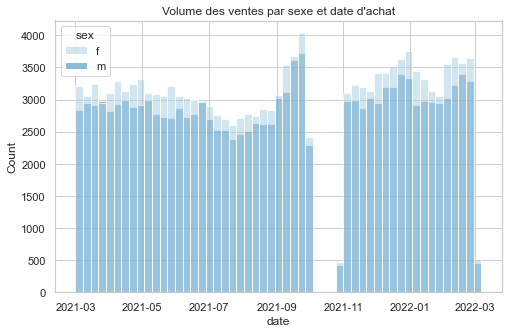

In [300]:
plt.figure(figsize=(8,5))
sns.histplot(data=b2c, x='date', hue='sex', binwidth=7)
plt.title('Volume des ventes par sexe et date d\'achat')
plt.savefig(url_fig + 'histogramme_date-sexe.png', dpi=300, bbox_inches='tight')
plt.show()

Les effectifs de ventes pour chaque sexe sont équilibrés. Les catégories y apparaissent dans les mêmes proportions.

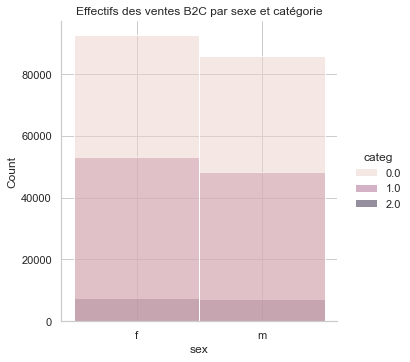

In [301]:
sns.displot(data=b2c, x='sex', hue='categ')
plt.title('Effectifs des ventes B2C par sexe et catégorie')
plt.savefig(url_fig + 'displot_sex-categorie.png', dpi=300, bbox_inches='tight')
plt.show()

La distribution des prix est là aussi la même : toutes les corrélations ont été étudiées, le sexe ne nous renseigne pas sur les habitudes des clients.

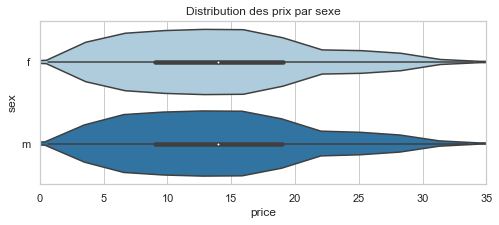

In [302]:
plt.figure(figsize=(8,3))
sns.violinplot(data=b2c, x='price', y='sex', showfliers=False, showmeans=True)
plt.xlim([0,35])
plt.title('Distribution des prix par sexe')
plt.savefig(url_fig + 'violinplot_sexe-prix.png', dpi=300, bbox_inches='tight')
plt.show()

Une matrice des corrélations aurait pu nous montrer cette absence de relation entre le sexe et toutes les autres variables. On doit d'abord encoder la variable *'sex'*. Les taux de corrélation approchent tous de 0, indiquant une absence de corrélation.

In [303]:
b2c = pd.concat([b2c,
    pd.get_dummies(b2c['sex'], drop_first=True).rename(columns={'m': 'sex_code'})],
    axis=1)
b2c.sample(3)

,index,id_prod,date,session_id,client_id,sex,birth,price,categ,mois,total_ventes,ventes_mensuelles,taille_panier_moyen,panier_moyen,total_achats,age,classe_age,client_type,sex_code
297651,317161,1_498,2021-05-14 08:04:36.461552,s_34310,c_6912,f,1949,23.37,1.00,5,23,2.00,1.77,18.66,425.09,72,70-80,B2C,0
238510,254171,1_556,2021-11-09 08:50:43.437451,s_116980,c_1540,m,1964,24.47,1.00,11,34,3.00,1.42,15.34,550.72,57,50-60,B2C,1
76600,81687,1_652,2022-02-22 21:32:55.948525,s_169323,c_2939,f,1987,27.52,1.00,2,76,7.00,2.81,13.40,966.67,34,30-40,B2C,0


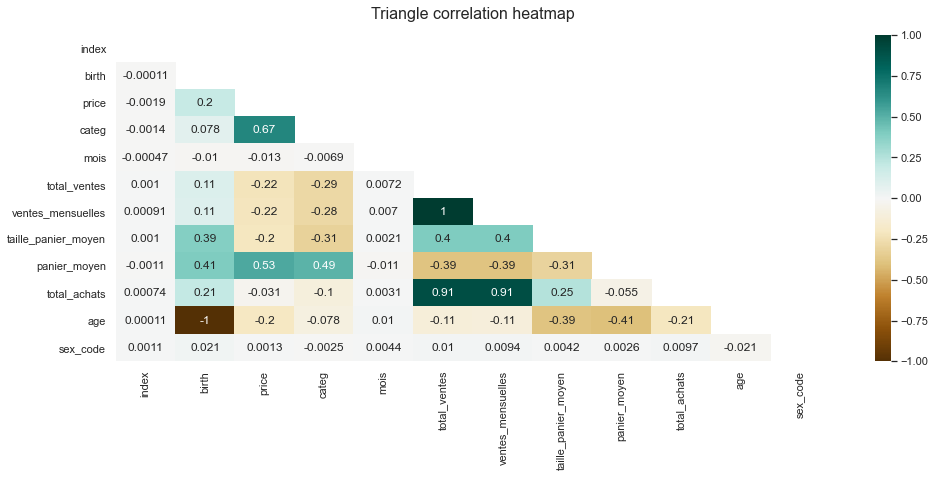

In [304]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(
    b2c.corr(), 
    mask=np.triu(np.ones_like(b2c.corr(), dtype=np.bool)), 
    vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle correlation heatmap', fontdict={'fontsize':16}, pad=16)
plt.show()

### Par âge

Les 30-50 ans représentent plus de la moitié des ventes.

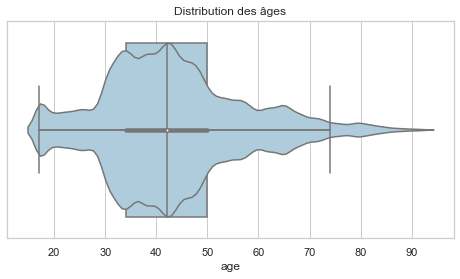

In [305]:
sns.boxplot(data=b2c, x='age', showfliers=False)
sns.violinplot(data=b2c, x='age', showfliers=False)
plt.title('Distribution des âges')
plt.savefig(url_fig + 'boxplot_age.png', dpi=300, bbox_inches='tight')
plt.show()

Les 3 catégories sont consommées par toutes les classes d'âge. Mais les acheteurs de la catégorie 0 sont principalement ces 30-50 ans, tandis que la catégorie 2 est consommée quasi exclusivement par les moins de 30 ans.

<Figure size 576x360 with 0 Axes>

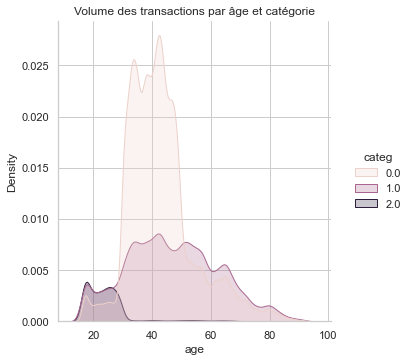

In [306]:
plt.figure(figsize=(8,5))
sns.displot(data=b2c, x='age', hue='categ', kind='kde', fill=True)
plt.title('Volume des transactions par âge et catégorie')
plt.savefig(url_fig + 'displot_age-categorie.png', dpi=300, bbox_inches='tight')
plt.show()

Comme c'était le cas avec un des clients professionnels, les moins de 30 ans affichent des prix d'achat bien plus hauts que les autres clients.

Les prix sont aussi légèrement inférieurs chez les 30-50 ans (population consommant la catégorie 0). 

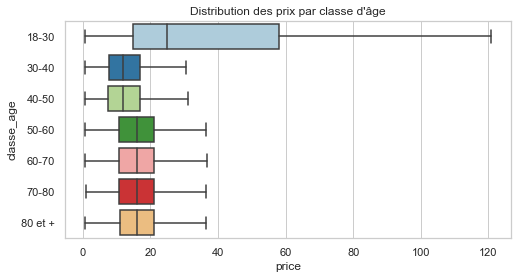

In [307]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df.sort_values(by='classe_age'), y='classe_age', x='price', showfliers=False)
plt.title('Distribution des prix par classe d\'âge')
plt.savefig(url_fig + 'boxplots_prix-classe-age.png', dpi=300, bbox_inches='tight')
plt.show()

Le chiffre d'affaires annuel des clients particuliers est logiquement corrélé à la classe d'âge, car comme vu plus tôt :

- la catégorie 0 est de loin la catégorie la plus consommée (par les 30-50 ans)
- la catégorie 2 est presque exclusivement achetée par les moins de 30 ans, en plus de concentrer les livres les plus chers

Les 30-50 ans concentrent ainsi les plus gros chiffres d'affaires, suivis par les moins de 30 ans.

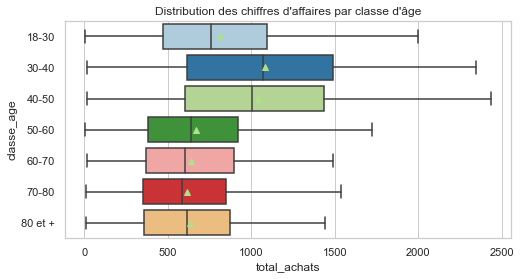

In [308]:
sns.boxplot(data=b2c.sort_values(by='classe_age'), 
            y='classe_age', x='total_achats', 
            showfliers=False, showmeans=True)
plt.title('Distribution des chiffres d\'affaires par classe d\'âge')
plt.savefig(url_fig + 'boxplots_ca-classe-age.png', dpi=300, bbox_inches='tight')
plt.show()

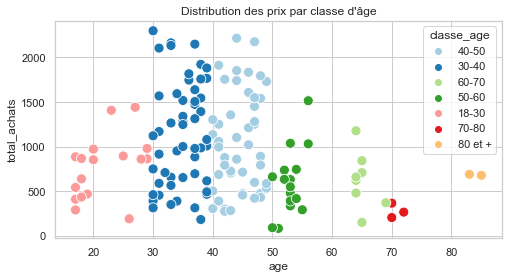

In [309]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=b2c.sample(150), x='age', y='total_achats', hue='classe_age', s=100)
plt.title('Distribution des prix par classe d\'âge')
plt.savefig(url_fig + 'scatterplot_prix-classe-age.png', dpi=300, bbox_inches='tight')
plt.show()

La fréquence d'achats (le nombre de livres par mois) classe d'autant mieux les 3 groupes d'individus définis plus tôt :

- les moins de 30 ans achètent le même nombre de livrees (jamais plus de 3 livres par mois)
- les 30-50 ans se démarquent : un quart de ces clients achète plus de 8 livres par mois.
- les plus de 50 ans ont des habitudes plus variées, mais achètent rarement plus de 5 livres

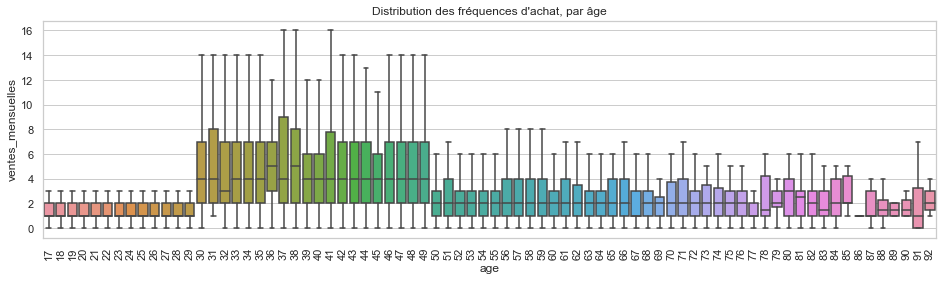

In [310]:
plt.figure(figsize=(16,4))
sns.boxplot(
    data=b2c.pivot_table(index=['client_id']),
    y='ventes_mensuelles', x='age', showfliers=False)
plt.xticks(rotation=90)
plt.title('Distribution des fréquences d\'achat, par âge')
plt.savefig(url_fig + 'boxplots_age-frequence.png', dpi=300, bbox_inches='tight')
plt.show()

La taille du panier moyen suit la même logique : 

- les moins de 30 ans comptent en moyenne moins de 2 livres par panier
- les 30-50 ans achètent 2 à 3 livres par commande
- les habitudes sont aléatoires chez les plus de 50 ans

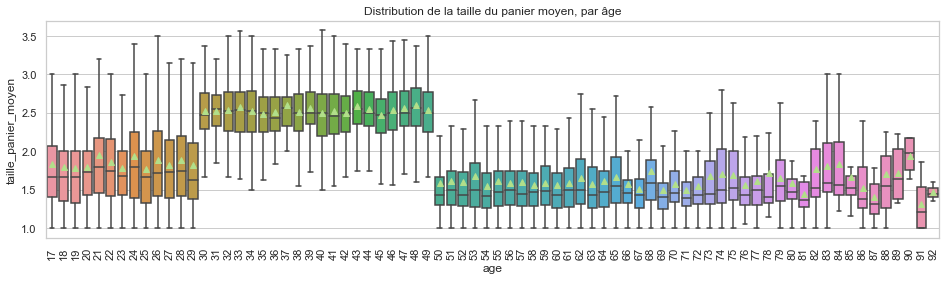

In [311]:
plt.figure(figsize=(16,4))
sns.boxplot(
    data=b2c.pivot_table(index=['client_id']),
    y='taille_panier_moyen', x='age', showfliers=False, showmeans=True)
plt.xticks(rotation=90)
plt.title('Distribution de la taille du panier moyen, par âge')
plt.savefig(url_fig + 'boxplots_age-panier-moyen.png', dpi=300, bbox_inches='tight')
plt.show()

[](http://)

## Produits

### Périodicité

Comme chez les clients professionnels, la périodicité des ventes apparaît corrélée à la catégorie :
    
- la **catégorie 0** à la rentrée scolaire de septembre
- la **catégorie 1** pendant les fêtes de fin d'année
- la **catégorie 2** pendant l'été et au mois de février (début du second semestre universitaire)

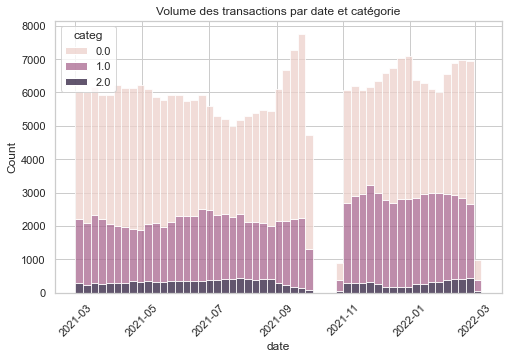

In [312]:
plt.figure(figsize=(8,5))
sns.histplot(data=b2c, x='date', hue='categ', multiple='stack', binwidth=7)
plt.xticks(rotation=45)
plt.title('Volume des transactions par date et catégorie')
plt.savefig(url_fig + 'histogramme_date_categorie.png', dpi=300, bbox_inches='tight')
plt.show()

Catégorie 0.0


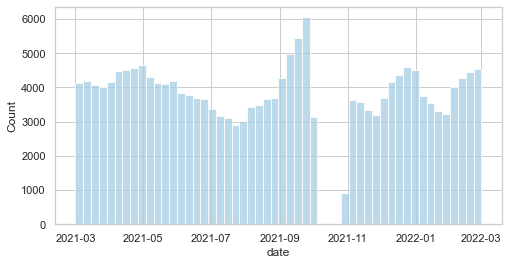

Catégorie 1.0


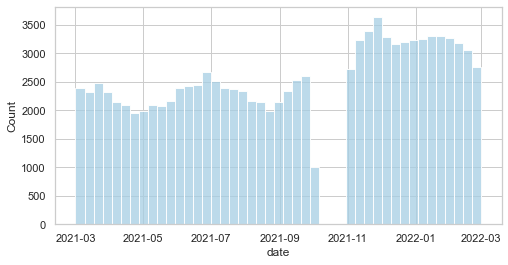

Catégorie 2.0


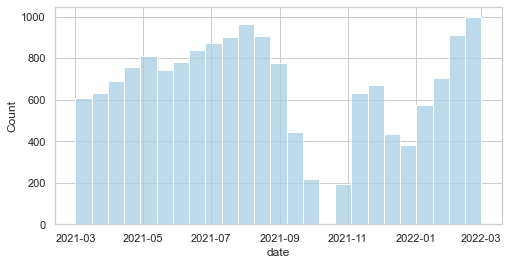

In [313]:
for i in sorted(df['categ'].unique()):
    print('Catégorie', i)
    sns.histplot(data=df[df['categ']==i], x='date')
    plt.show()

### Catégories et prix

La catégorie 0 représente 60% des ventes, la catégorie 2 seulement 5%. Malgré tout, les prix des catégories 2 et 1 entraînent une inégalité des chiffres d'affaires annuels par produit. 

c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\plotting\_matplotlib\core.py:1547: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


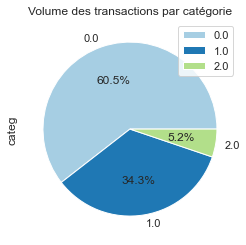

In [314]:
# Volume des ventes par catégorie
df['categ'].value_counts(normalize=True).plot(
    kind='pie',
    legend=True,
    autopct='%1.1f%%')
plt.title('Volume des transactions par catégorie')
plt.savefig(url_fig + 'pie_volume-catégories.png', dpi=300, bbox_inches='tight')
plt.show()

Les livres aux plus hauts chiffre d'affaires appartiennent tous aux catégories 1 et 2.

In [315]:
# Les 20 livres aux plus gros chiffres d'affaires annuels
df.pivot_table(index=['id_prod', 'categ'], aggfunc={'price': np.sum}).sort_values(by='price', ascending=False).reset_index().head(10)

,id_prod,categ,price
0,2_135,2.00,"32,011.36"
1,2_112,2.00,"29,392.95"
2,2_102,2.00,"27,263.54"
3,2_209,2.00,"25,826.31"
4,1_369,1.00,"25,669.30"
5,1_395,1.00,"25,569.18"
6,2_110,2.00,"25,086.75"
7,1_383,1.00,"24,670.49"
8,1_414,1.00,"24,235.11"
9,2_166,2.00,"24,154.20"


L'indice de Gini est plus élevé encore que celui des chiffres d'affaires des clients.

Incide de Gini : 0.741453116630536


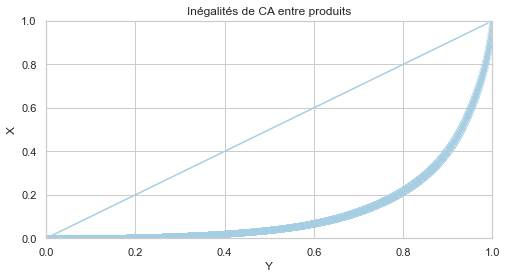

In [316]:
# Inégalités des chiffres d'affaires annuels par produit
lorenz(df.pivot_table(index='id_prod', aggfunc='sum')['price'], 'Inégalités de CA entre produits')

Les proportions du chiffre d'affaires sont beaucoup plus équilibrées : la catégorie 0 ne représente finalement qu'un tiers du chiffre d'affaires.

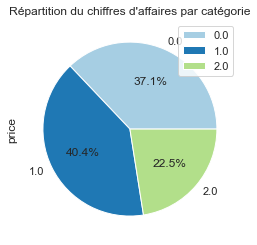

In [317]:
# Chiffre d\'affaires par catégorie
data=df.pivot_table(index='categ', aggfunc={'price': np.sum}).plot(
    kind='pie', y='price',
    legend=True,
    autopct='%1.1f%%'
)
plt.title('Répartition du chiffres d\'affaires par catégorie')
plt.savefig(url_fig + 'pie_ca-categories.png', dpi=300, bbox_inches='tight')
plt.show()

Les indicateurs prix sont distinctement ordonnés entre catégories.  

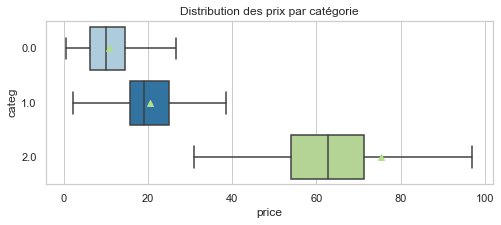

In [318]:
plt.figure(figsize=(8,3))
sns.boxplot(
    data=df, y='categ', x='price', 
    showmeans=True, showfliers=False, orient='h')
plt.title('Distribution des prix par catégorie')
plt.savefig(url_fig + 'boxplots_prix-categorie.png', dpi=300, bbox_inches='tight')
plt.show()

In [319]:
# Indicateurs de position des prix dans chaque catégorie
for i in sorted(df['categ'].unique()):
    print('Catégorie', i)
    print(pd.Series(df[df['categ']==i]['price'].describe()), '\n')

Catégorie 0.0
count   191,326.00
mean         10.65
std           4.93
min           0.62
25%           6.30
50%           9.99
75%          14.45
max          40.99
Name: price, dtype: float64 

Catégorie 1.0
count   108,411.00
mean         20.49
std           7.58
min           2.00
25%          15.81
50%          19.08
75%          24.98
max          80.99
Name: price, dtype: float64 

Catégorie 2.0
count   16,433.00
mean        75.25
std         39.19
min         30.99
25%         53.99
50%         62.83
75%         71.21
max        300.00
Name: price, dtype: float64 



# Tests

## Catégorie et âge (ANOVA)

L'analyse de la variance est utile pour vérifier la corrélation entre une qualitative et une quantitative.

Avant de faire une ANOVA, on affiche la moyenne des âge dans chaque catégorie. La catégorie 2 se détache, mais les catégories 0 et 1 ont des moyennes assez proches : le test va permettre de vérifier si leur distance est significative.

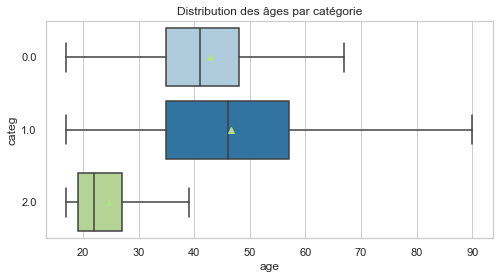

In [320]:
sns.boxplot(data=df, x='age', y='categ', orient='h', showfliers=False, showmeans=True)
plt.title('Distribution des âges par catégorie')
plt.savefig(url_fig + 'boxplots_age-categorie.png', dpi=300, bbox_inches='tight')
plt.show()

In [321]:
# Moyenne des prix par catégorie
df.groupby('categ').mean()['age']

categ
0.00   42.91
1.00   46.65
2.00   24.71
Name: age, dtype: float64

In [322]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

# Test d'ANOVA
sample_df = df.sample(5000)
model = smf.ols('age ~ categ', data=sample_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
p = anova_table['PR(>F)'][0]
print('ANOVA\np-value :', p, '\nstat (F) :', anova_table['F'][0])
if p > 0.05:
    print('H0: the means of the samples are equal.')
else:
    print('H1: one or more of the means of the samples are unequal.'
         '\n\nConditions :'
         '\n1. Normalité des résidus\n2. Homoscédasticité')

ANOVA
p-value : 3.8542282081509824e-10 
stat (F) : 39.343304046808804
H1: one or more of the means of the samples are unequal.

Conditions :
1. Normalité des résidus
2. Homoscédasticité


Mais la distribution des résidus n'est pas normale.

Normalité des résidus (Shapiro)

stats : 0.9671338200569153 
p-value : 2.501006466190866e-32
H0 rejetée : distribution probablement pas normale


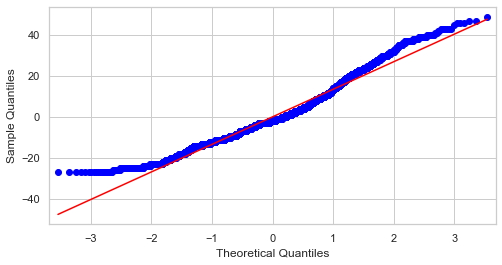

In [323]:
from statsmodels.graphics.gofplots import qqplot

# Test de Shapiro sur les résidus
print('Normalité des résidus (Shapiro)')
print('\nstats :', stats.shapiro(model.resid)[0],
    '\np-value :', stats.shapiro(model.resid)[1])
if p>.05:
    print('H0 acceptée : distribution normale')
else:
    print('H0 rejetée : distribution probablement pas normale')
qqplot(model.resid, line='s')
plt.show()

Après un boxcox les résidus sont considérés comme normaux : la première condition de l'ANOVA est remplie.

Normalité des résidus après boxcox :
stats : nan 
p-value : 1.0
H0 acceptée : distribution normale


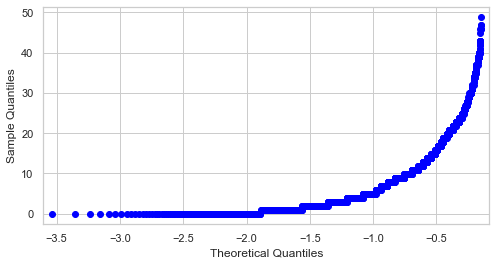

In [324]:
from scipy.special import boxcox1p

# Test de Shapiro sur les résidus après boxcox
residus = boxcox1p(model.resid, 1)
p = stats.shapiro(residus)[1]
print('Normalité des résidus après boxcox :'
    '\nstats :', stats.shapiro(residus)[0],
    '\np-value :', p)
if p>.05:
    print('H0 acceptée : distribution normale')
else:
    print('H0 rejetée : distribution probablement pas normale')
qqplot(residus, line='s')
plt.show()

Reste à tester l'homoscédasticité des résidus, pour s'assurer que les variances sont égales. Le test de Levene n'est pas concluant. Dans le cas où la condition d'homoscédasticité n'est pas remplie, on peut utiliser Welch ANOVA : ce test valide ici la corrélation entre prix et catégorie.

In [325]:
# Test de Levene sur les 3 catégories
samples = 4000
a = df[df['categ']==0]['age'].sample(samples).values
b = df[df['categ']==1]['age'].sample(samples).values
c = df[df['categ']==2]['age'].sample(samples).values
stat, p = stats.levene(a, b, c)
print('Condition 2 : homoscédasticité (Levene)',
    '\nstats :', stat,
    '\np-value :', p)
if p > 0.05:
    print('H0: les variances sont égales')
else:
    print('H1: les variances ne sont pas égales (essayer Welch ANOVA)')
print('\nConditions :'
      '\n- The samples from the populations under consideration are independent',
      '\n- The populations under consideration are approximately normally distributed')   

Condition 2 : homoscédasticité (Levene) 
stats : 787.5698183306241 
p-value : 4.25e-322
H1: les variances ne sont pas égales (essayer Welch ANOVA)

Conditions :
- The samples from the populations under consideration are independent 
- The populations under consideration are approximately normally distributed


In [326]:
# Test de Welch entre catégorielle et quantitative
stat, p = stats.ttest_ind(sample_df['age'], sample_df['categ'])
print('Test de Welch (si absence d\'homoscédasticité)\n')
print('p-value :', p, '\nstat :', stat)
if p > 0.05:
    print('H0: les moyennes des échantillons sont égales')
else:
    print('H1: une ou plus des moyennes des échantillons sont inégales')

Test de Welch (si absence d'homoscédasticité)

p-value : 0.0 
stat : 223.68289726124746
H1: une ou plus des moyennes des échantillons sont inégales


## Catégorie et sexe (Chi 2)

Le test d'indépendance du χ² mesure la corrélation entre 2 variables qualitatives.

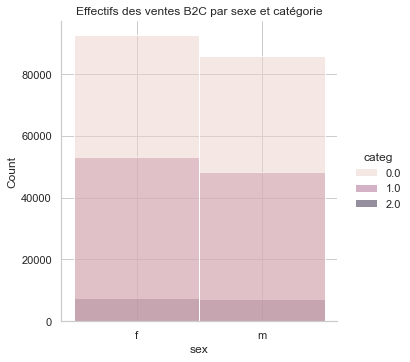

In [327]:
sns.displot(data=b2c, x='sex', hue='categ')
plt.title('Effectifs des ventes B2C par sexe et catégorie')
plt.show()

In [328]:
pip install researchpy

Note: you may need to restart the kernel to use updated packages.


La cardinalité est le nombre de modalités dans les 2 qualitatives à étudier. Plus la cardinalité sera grande, plus il sera difficile de séparer distinctement les groupes.

On mesure cette cardinalité en *degrés de liberté* :

> Degrés de liberté = ( nombre de modalités variable_A - 1 ) x ( nombre de modalités variable_B - 1 )

On obtient donc 2 degrés de liberté dans la table de contingence entre *'categ'* et *'sex'*.

In [329]:
# Table de contingence
crosstab = pd.crosstab(b2c['categ'], b2c['sex'], margins=False)
print('Table de contingence :')
print(crosstab)

import researchpy as rp

# Table de contingence normalisée
table, results = rp.crosstab(b2c['categ'], b2c['sex'], prop='col', test='chi-square')
print('\n' + '-' * 55, '\n\nTable de contingence normalisée :')
print(table)

Table de contingence :
sex        f      m
categ              
0.00   92617  85774
1.00   53161  48221
2.00    7599   7136

------------------------------------------------------- 

Table de contingence normalisée :
         sex              
sex        f      m    All
categ                     
0.0    60.39  60.78  60.57
1.0    34.66  34.17  34.42
2.0     4.95   5.06   5.00
All   100.00 100.00 100.00


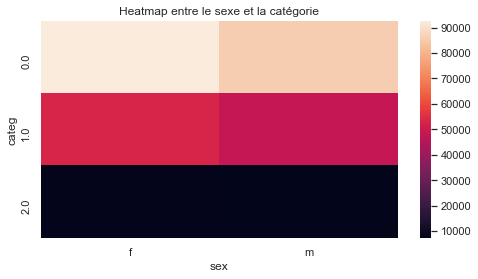

In [330]:
sns.heatmap(crosstab)
plt.title('Heatmap entre le sexe et la catégorie')
plt.savefig(url_fig + 'heatmap_sexe-categorie.png', dpi=300, bbox_inches='tight')
plt.show()

Conditions

Le test de normalité ne fait pas partie des conditions du khi-deux, vu qu'on ne mesure pas la normalité que sur des variables quantitatives.

On doit malgré tout valider 2 conditions : 
- au moins 1 valeur dans chaque cellule de la table de contingence
- au moins 80% des valeurs égales ou supérieures à 5
    
Ces conditions étant remplies, la p-value confirme l'hypothèse 0, et l'absence corrélation entre les catégories et le sexe. 

In [331]:
# Test de Chi 2
sample_df = b2c.sample(1500)
table = pd.crosstab(sample_df['categ'], sample_df['sex'], margins=False)
stat, p, dof, expected = stats.chi2_contingency(table)
print('Test de Chi 2 (2 catégorielles)')
print('Stat = %.3f\np-value = %.35f' % (stat, p))
if p > .05:
    print('H0: the two samples are independent')
else:
    print('H1: there is a dependency between the samples.')
print('\nConditions :\n'
      '- Observations used in the calculation of the contingency table are independent.',
      '\n- 25 or more examples in each cell of the contingency table.')

Test de Chi 2 (2 catégorielles)
Stat = 3.400
p-value = 0.18266265404868811672578488014551112
H0: the two samples are independent

Conditions :
- Observations used in the calculation of the contingency table are independent. 
- 25 or more examples in each cell of the contingency table.


# Références

- [StatQuest - Statistics Fundamentals](https://www.youtube.com/playlist?list=PLblh5JKOoLUK0FLuzwntyYI10UQFUhsY9)
- [Plot Lorenz Curve in Python](https://zhiyzuo.github.io/Plot-Lorenz/)
- [Clearly Explained: Gini coefficient and Lorenz curve](https://towardsdatascience.com/clearly-explained-gini-coefficient-and-lorenz-curve-fe6f5dcdc07)  
- [17 Statistical Hypothesis Tests in Python (Cheat Sheet)](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/)
- [Independent and identically distributed random variables](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)
- [Q-Q Plots Explained](https://medium.com/preai/q-q-plots-explained-75f5bc6d68be)
- [ANOVA explained without math: Why analyze variances to compare means?](https://medium.com/@peterflom/anova-why-analyze-variances-to-compare-means-e3d4bbd3c05)
- [ANOVA using Python](https://reneshbedre.github.io/blog/anova.html)
- [F-tests and ANOVAs — Examples with the Iris dataset](https://medium.com/@rrfd/f-tests-and-anovas-examples-with-the-iris-dataset-fe7caa3e21d0)
- [Welch’s t-test](https://pythonfordatascienceorg.wordpress.com/welch-t-test-python-pandas/)
- [Getting Started With Titanic](https://www.kaggle.com/alexisbcook/getting-started-with-titanic)
- [Stackoverflow](https://stackoverflow.com/questions/41925157/logisticregression-unknown-label-type-continuous-using-sklearn-in-python)